In [1]:
# importing packages for project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import scipy as sc
# from scipy.stats import norm
# from scipy.stats import binom
# from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from bs4 import BeautifulSoup
import urllib.request
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor



# Part 1 Data Acquisition

Check out the robots.txt file for HN to make sure you're allowed to scrape it for stories.

Grab the first 5 pages of stories from hackernews. For each story, grab the following data:

Rank (the number of the story on hacker news)
Length of the title
Age, in hours (note, some stories are days or minutes old. You should be able to handle this)
Points (note, some stories don't have scores! Give them 0 points)
Number of comments (again, some stories have no comments. Mark them 0)
A lot of HTML on HN has handy class attributes to help make this task a bit easier. Once you have all your data, create a dataframe to store it, and save a CSV file so you don't have to hit the server repeatedly to reload the data.

Most of the table entries are nicely, uniformly formatted, but a few might be missing fields. I'd suggest testing with the common case and fixing edge cases as they come up.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Base URL for Hacker News
base_url = "https://news.ycombinator.com/news?p="
# Number of pages to scrape
pages = 5

# List to store the data
data = []

# Loop through the specified number of pages
for page in range(1, pages + 1):
    # Construct the URL for the current page
    url = f"{base_url}{page}"
    # Fetch the page content
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all the story elements
    story_elements = soup.find_all('tr', class_='athing')

    for story in story_elements:
        # Rank
        rank = story.find('span', class_='rank').text.strip('.')
        
        # Title and its length
        title_element = story.find('a', class_='storylink')
        if title_element:
            title = title_element.text
            title_length = len(title)
        else:
            title = ""
            title_length = 0
        
        # Age (in hours)
        age_element = story.find_next_sibling('tr').find('span', class_='age')
        age_text = age_element.text
        if 'minute' in age_text:
            age_in_hours = int(age_text.split()[0]) / 60
        elif 'hour' in age_text:
            age_in_hours = int(age_text.split()[0])
        elif 'day' in age_text:
            age_in_hours = int(age_text.split()[0]) * 24
        else:
            age_in_hours = 0
        
        # Points
        points_element = story.find_next_sibling('tr').find('span', class_='score')
        points = int(points_element.text.split()[0]) if points_element else 0
        
        # Number of comments
        comments_element = story.find_next_sibling('tr').find_all('a')[-1]
        comments_text = comments_element.text
        comments = int(comments_text.split()[0]) if 'comment' in comments_text else 0
        
        # Append the data
        data.append([int(rank), title_length, age_in_hours, points, comments])

# Create a DataFrame
columns = ['Rank', 'Title_Length', 'Age_in_Hours', 'Points', 'Comments']
df = pd.DataFrame(data, columns=columns)

# Save to CSV
df.to_csv('hacker_news_stories.csv', index=False)

print("Data has been saved to hacker_news_stories.csv")


Data has been saved to hacker_news_stories.csv


# Part 2 Regression

We're interested in how to get a high-ranking story on Hackernews. Explore several possible least squares regressions to predict a story's rank based on the other variables (or combinations thereof). Include at least 3 different regressions. Compare/contrast them. Which is the most useful. Are there linear relationships between any of the variables? How about other relationships like inverse linear (1/x)?

In [3]:
# Load the data
df = pd.read_csv('hacker_news_stories.csv')
print(df.head())
X = df['Points']
X = sm.add_constant(X)
y = df['Rank']
model1 = sm.OLS(y, X).fit()
print(model1.summary())


X = df[['Title_Length', 'Age_in_Hours', 'Points', 'Comments']]
X = sm.add_constant(X)
# Fit the model
model2 = sm.OLS(y, X).fit()
# Print the summary
print(model2.summary())

# Create polynomial features (degree 2)
X_poly = df[['Title_Length', 'Age_in_Hours', 'Points', 'Comments']]
X_poly['Title_Length^2'] = X_poly['Title_Length'] ** 2
X_poly['Age_in_Hours^2'] = X_poly['Age_in_Hours'] ** 2
X_poly['Points^2'] = X_poly['Points'] ** 2
X_poly['Comments^2'] = X_poly['Comments'] ** 2
X_poly['Title_Length*Age_in_Hours'] = X_poly['Title_Length'] * X_poly['Age_in_Hours']
X_poly['Title_Length*Points'] = X_poly['Title_Length'] * X_poly['Points']
X_poly['Title_Length*Comments'] = X_poly['Title_Length'] * X_poly['Comments']
X_poly['Age_in_Hours*Points'] = X_poly['Age_in_Hours'] * X_poly['Points']
X_poly['Age_in_Hours*Comments'] = X_poly['Age_in_Hours'] * X_poly['Comments']
X_poly['Points*Comments'] = X_poly['Points'] * X_poly['Comments']

X_poly = sm.add_constant(X_poly)

# Fit the polynomial regression model
model3 = sm.OLS(y, X_poly).fit()
# Print the summary
print(model3.summary())


# Compare R-squared values
r_squared_simple = model1.rsquared
r_squared_multiple = model2.rsquared
r_squared_poly = model3.rsquared

print(f'Simple Linear Regression R-squared: {r_squared_simple}')
print(f'Multiple Linear Regression R-squared: {r_squared_multiple}')
print(f'Polynomial Regression R-squared: {r_squared_poly}')

# Compare RMSE values
rmse_simple = np.sqrt(model1.mse_resid)
rmse_multiple = np.sqrt(model2.mse_resid)
rmse_poly = np.sqrt(model3.mse_resid)

print(f'Simple Linear Regression RMSE: {rmse_simple}')
print(f'Multiple Linear Regression RMSE: {rmse_multiple}')
print(f'Polynomial Regression RMSE: {rmse_poly}')


   Rank  Title_Length  Age_in_Hours  Points  Comments
0     1             0           3.0     182        51
1     2             0           1.0      44        21
2     3             0           5.0     232        82
3     4             0           4.0     133        66
4     5             0           4.0      72        25
                            OLS Regression Results                            
Dep. Variable:                   Rank   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                   0.06266
Date:                Thu, 06 Jun 2024   Prob (F-statistic):              0.803
Time:                        11:25:01   Log-Likelihood:                -595.64
No. Observations:                 120   AIC:                             1195.
Df Residuals:                     118   BIC:                             1201.
Df Model:                           1       

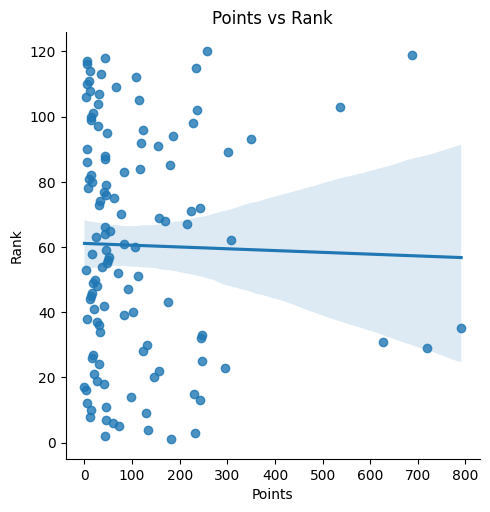

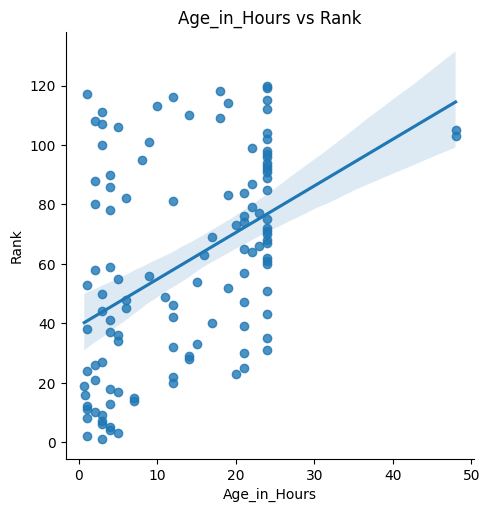

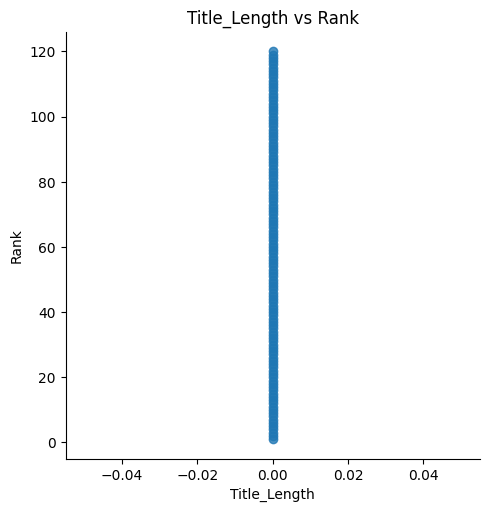

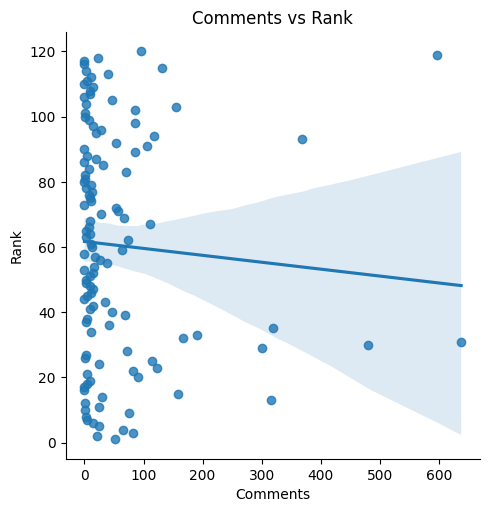

In [4]:
# Scatter plot for Points vs Rank with regression line
sns.lmplot(x='Points', y='Rank', data=df)
plt.title('Points vs Rank')
plt.show()

# Scatter plot for Age_in_Hours vs Rank with regression line
sns.lmplot(x='Age_in_Hours', y='Rank', data=df)
plt.title('Age_in_Hours vs Rank')
plt.show()

# Scatter plot for Title_Length vs Rank with regression line
sns.lmplot(x='Title_Length', y='Rank', data=df)
plt.title('Title_Length vs Rank')
plt.show()

# Scatter plot for Comments vs Rank with regression line
sns.lmplot(x='Comments', y='Rank', data=df)
plt.title('Comments vs Rank')
plt.show()

# Part 3 Classification
As smart people, we know that your rank on HN doesn't matter, as long as you're on the front page. Use logistic regression to attempt to classify whether or not an article will be on the front page, given the other (non-rank) variables. Note, you'll need to transform the rank variable into an indicator variable (1 for front page, 0 for not), for example.

Include plots showing your regression (for the functions of 1 or 2 variables). What do your regressions tell you about making the front page?

In [5]:
df = pd.read_csv('hacker_news_stories.csv')

variables = df[['Title_Length', 'Age_in_Hours', 'Points', 'Comments']]
print("Correlation matrix:\n", variables.corr())

vif_data = pd.DataFrame()
vif_data["feature"] = variables.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
print(vif_data)

Correlation matrix:
               Title_Length  Age_in_Hours    Points  Comments
Title_Length           NaN           NaN       NaN       NaN
Age_in_Hours           NaN      1.000000  0.458983  0.285567
Points                 NaN      0.458983  1.000000  0.801812
Comments               NaN      0.285567  0.801812  1.000000
        feature       VIF
0  Title_Length       NaN
1  Age_in_Hours  2.036135
2        Points  5.215615
3      Comments  3.652720


/Users/samanthapope/MSD/Github/CS6017/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Optimization terminated successfully.
         Current function value: 0.391346
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 19
                           Logit Regression Results                           
Dep. Variable:             Front_Page   No. Observations:                  120
Model:                          Logit   Df Residuals:                      116
Method:                           MLE   Df Model:                            3
Date:                Thu, 06 Jun 2024   Pseudo R-squ.:                  0.3041
Time:                        11:25:01   Log-Likelihood:                -46.961
converged:                       True   LL-Null:                       -67.480
Covariance Type:            nonrobust   LLR p-value:                 6.420e-09
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4056      0.363

/Users/samanthapope/MSD/Github/CS6017/.venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/samanthapope/MSD/Github/CS6017/.venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


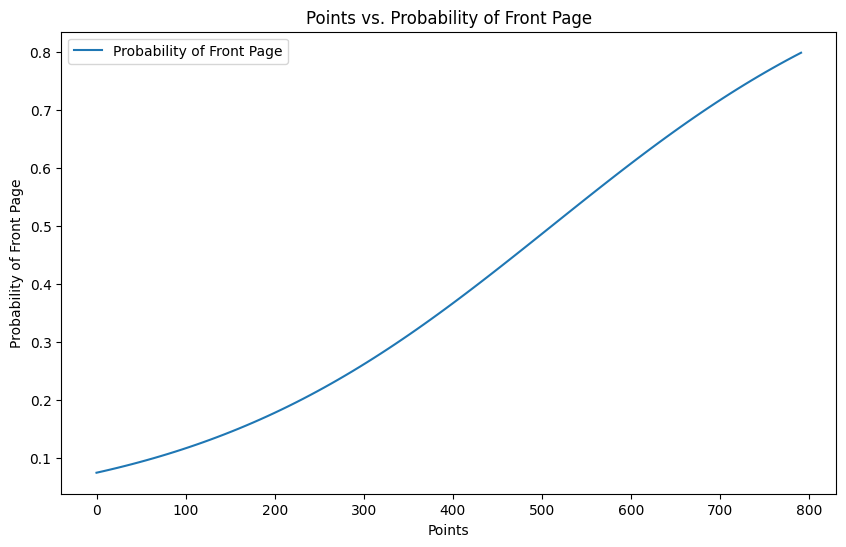

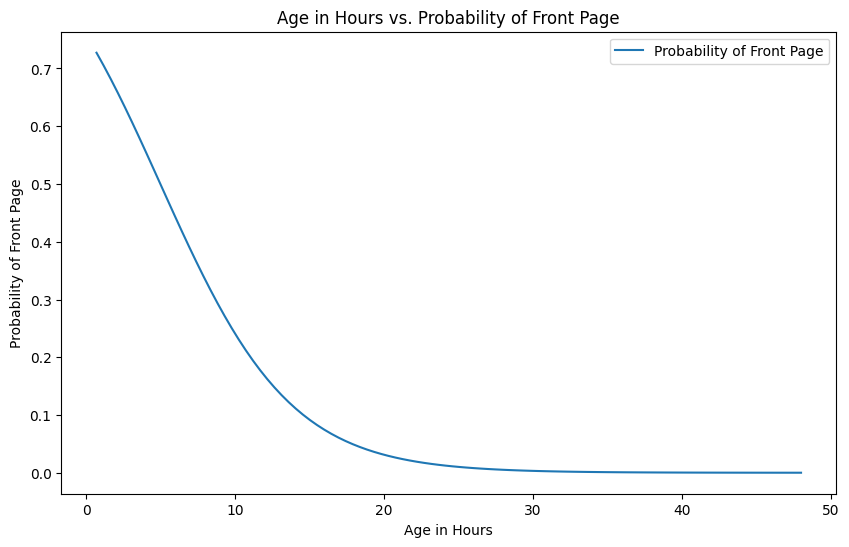

In [6]:
# Create the Front_Page indicator variable
df['Front_Page'] = (df['Rank'] <= 30).astype(int)

# Logistic Regression
X = df[['Title_Length', 'Age_in_Hours', 'Points', 'Comments']]
X = sm.add_constant(X)
y = df['Front_Page']
logit_model = sm.Logit(y, X).fit(method='bfgs')

# Print the summary
print(logit_model.summary())

# Plotting Points vs. Probability of Front Page
points = np.linspace(df['Points'].min(), df['Points'].max(), 100)
X_plot = pd.DataFrame({
    'const': 1,
    'Title_Length': np.mean(df['Title_Length']),
    'Age_in_Hours': np.mean(df['Age_in_Hours']),
    'Points': points,
    'Comments': np.mean(df['Comments'])
})
pred_probs = logit_model.predict(X_plot)

plt.figure(figsize=(10, 6))
plt.plot(points, pred_probs, label='Probability of Front Page')
plt.xlabel('Points')
plt.ylabel('Probability of Front Page')
plt.title('Points vs. Probability of Front Page')
plt.legend()
plt.show()

# Plotting Age_in_Hours vs. Probability of Front Page
ages = np.linspace(df['Age_in_Hours'].min(), df['Age_in_Hours'].max(), 100)
X_plot = pd.DataFrame({
    'const': 1,
    'Title_Length': np.mean(df['Title_Length']),
    'Age_in_Hours': ages,
    'Points': np.mean(df['Points']),
    'Comments': np.mean(df['Comments'])
})
pred_probs = logit_model.predict(X_plot)

plt.figure(figsize=(10, 6))
plt.plot(ages, pred_probs, label='Probability of Front Page')
plt.xlabel('Age in Hours')
plt.ylabel('Probability of Front Page')
plt.title('Age in Hours vs. Probability of Front Page')
plt.legend()
plt.show()
